In [30]:
import torch
import sys
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import importlib.util

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#from data_aug.gaussian_blur import GaussianBlur
from torchvision import datasets
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import zipfile
from copy import deepcopy



import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import time
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
)
import torchvision.models as models

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# vision transformer
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor, ViTForImageClassification




## Custom Galaxy Zoo 2 Dataset
class GalaxyZooDataset(Dataset):
    """Galaxy Zoo Dataset"""

    def __init__(self, csv_file, images_dir, transform=None):
        """
        Args:
            csv_file (string): path to the label csv
            images_dir (string): path to the dir containing all images
            transform (callable, optional): transform to apply
        """
        self.labels_df = csv_file # pd.read_csv(csv_file)
        self.labels_df = self.labels_df[['galaxyID', 'label1']].copy()
        

        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        """
        Returns the size of the dataset
        """
        return len(self.labels_df)

    def __getitem__(self, idx):
        """
        Get the idx-th sample.
		Outputs the image (channel first) and the true label
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # galaxy ID
        galaxyid = self.labels_df.iloc[idx, 0].astype(str)
		# path of the image
        image_path = os.path.join(self.images_dir, galaxyid + '.jpg')
		# read the image
        image = Image.open(image_path)
		# apply transform (optional)
        if self.transform is not None:
            image = self.transform(image)
		# read the true label
        label = int(self.labels_df.iloc[idx, 1])
        image = image.squeeze(0)
        
        
        image = image.numpy()
        image = np.moveaxis(image, 0, -1)
        return image #, label, int(galaxyid)

cuda:0


In [31]:
!pwd

/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification


In [32]:
image_dir = '../../galaxy_zoo_2/images_gz2/images/'

In [33]:
train_df = pd.read_csv('./gz2_data/gz2_train.csv')
valid_df = pd.read_csv('./gz2_data/gz2_valid.csv')
test_df = pd.read_csv('./gz2_data/gz2_test.csv')

train_df

,galaxyID,label1,label2,label3,label4
0,41793,0,0,0,0
1,220034,2,0,0,0
2,208678,7,4,3,2
3,1469,1,0,0,0
4,95302,4,2,1,1
...,...,...,...,...,...
99803,21184,2,0,0,0
99804,187872,5,2,1,1
99805,87283,0,0,0,0
99806,138098,0,0,0,0


In [34]:
def create_data_transforms(is_for_inception=False):
    """
    Create Pytorch data transforms for the GalaxyZoo datasets.
    Args:
        is_for_inception (bool): True for inception neural networks
    Outputs:
        train_transform: transform for the training data
        test_transform: transform for the testing data
    """
    if is_for_inception:
        input_size = 299
    else:
        input_size = 224

    # transforms for training data
    train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.99, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor()])# ,
                                          #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # transforms for validation data
    valid_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.ToTensor()])# ,
                                          #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # transforms for test data
    test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor()])# ,
                                         #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    
    return train_transform, valid_transform, test_transform

In [35]:
# the batch size
BATCH_SIZE = 64

# create transforms
train_transform, valid_transform, test_transform = create_data_transforms(is_for_inception=False)

# create datasets
data_train = GalaxyZooDataset(train_df, image_dir, train_transform)
data_valid = GalaxyZooDataset(valid_df, image_dir, valid_transform)
data_test = GalaxyZooDataset(test_df, image_dir, test_transform)

# dataloaders
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

# check the sizes
print("**Dataloaders**")
print("Number of training data: {} ({} batches)".format(len(data_train), len(train_loader)))
print("Number of validation data: {} ({} batches)".format(len(data_valid), len(valid_loader)))
print("Number of test data: {} ({} batches)".format(len(data_test), len(test_loader)))
print("===============================")

**Dataloaders**
Number of training data: 99808 (1560 batches)
Number of validation data: 24952 (390 batches)
Number of test data: 31191 (488 batches)


In [36]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

Torch-Version 1.8.1+cu102
DEVICE: cuda


In [37]:
# train_list = []
# t1 = time.time

# train_list = list(data_train)
# for i, data in enumerate(data_train):
#     #print(data.shape)
#     #sample_image = np.moveaxis(data, 0, -1)
# #     sample_image = np.zeros((224, 224, 3))
# #     for idx in range(3):
# #         sample_image[:, :, idx] += data[idx, :, :]
    
    
#     train_list.append(data)
#     if i == 1000:
#         break

In [38]:
def get_complete_transform(output_shape, kernel_size, s=1.0):
    """
    The color distortion transform.
    
    Args:
        s: Strength parameter.
    
    Returns:
        A color distortion transform.
    """
    rnd_crop = RandomResizedCrop(scale=(0.4, 1.0),size = output_shape)
    rnd_flip = RandomHorizontalFlip(p=0.5)
    
    color_jitter = ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = RandomApply([color_jitter], p=0.5)
    
    rnd_gray = RandomGrayscale(p=0.5)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    rnd_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    to_tensor = ToTensor()
    image_transform = Compose([
        to_tensor,
        rnd_crop,
        rnd_flip,
        rnd_color_jitter,
        rnd_gray,
        rnd_gaussian_blur,
    ])
    return image_transform


class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views
    
class CustomDataset(Dataset):
    """Flowers Dataset"""

    def __init__(self, list_images, transform=None):
        """
        Args:
            list_images (list): List of all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_images = list_images
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = self.list_images[idx]
        

        #image = np.expand_dims(image, axis=2)
        #image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)
        #image = image.reshape((224,224,3))
        
        return image 


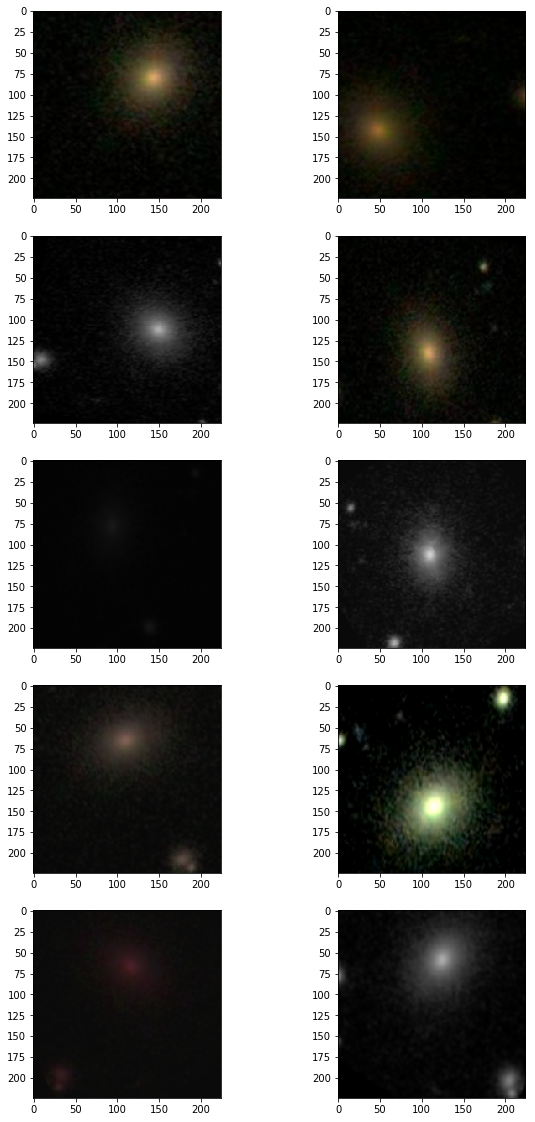

In [39]:


# The size of the images
output_shape = [224,224]
kernel_size = [21,21] # 10% of the output_shape

# The custom transform
base_transforms = get_complete_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

train_ds = CustomDataset(
    list_images=data_train,
    transform=custom_transform
)


plt.figure(figsize=(10,20))
def view_data(flowers, index):
    for i in range(1,6):
        images = flowers[index]
        view1, view2 = images
        #print(view1)
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1, 2, 0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1, 2, 0))

view_data(train_ds,25)


In [40]:


BATCH_SIZE = 128

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)



In [41]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        resnet18 = models.resnet18(pretrained=False)
        resnet18.fc = Identity()
        self.encoder = resnet18
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)
        
        encoding = self.encoder(x)
        projection = self.projection(encoding) 
        return projection


In [42]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

def cont_loss(features, temp):
    """
    The NTxent Loss.
    
    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch
    
    Returns:
        the NTxent loss
    """
    similarity_matrix = torch.matmul(features, features.T) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 128, 1
    
    #print("positives", positives[0][0])

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126
    ###
    
    #negatives *= 0
    #print("negatives", negatives[0][0])
    
    p_sample = positives[0][0]
    n_sample = negatives[0][0]
    

    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / temp
    return logits, labels, p_sample, n_sample


In [43]:

simclr_model = SimCLR().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(simclr_model.parameters())



In [44]:
p_sample_list = []
n_sample_list = []

EPOCHS = 10
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, views in enumerate(train_dl):
        projections = simclr_model([view.float().to(DEVICE) for view in views])
        logits, labels, p_sample, n_sample = cont_loss(projections, temp=2)
        logits, labels = logits.to(DEVICE), labels.to(DEVICE)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            running_loss = 0.0
            p_sample_list.append(p_sample)
            n_sample_list.append(n_sample)
            #break
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')


EPOCH: 1 BATCH: 50 LOSS: 2.6767 
EPOCH: 1 BATCH: 100 LOSS: 2.4838 
EPOCH: 1 BATCH: 150 LOSS: 2.2988 
EPOCH: 1 BATCH: 200 LOSS: 2.0883 
EPOCH: 1 BATCH: 250 LOSS: 1.8110 
EPOCH: 1 BATCH: 300 LOSS: 1.6231 
EPOCH: 1 BATCH: 350 LOSS: 1.4294 
EPOCH: 1 BATCH: 400 LOSS: 1.2802 
EPOCH: 1 BATCH: 450 LOSS: 1.1646 
EPOCH: 1 BATCH: 500 LOSS: 1.0652 
EPOCH: 1 BATCH: 550 LOSS: 0.9857 
EPOCH: 1 BATCH: 600 LOSS: 0.9390 
EPOCH: 1 BATCH: 650 LOSS: 0.8440 
EPOCH: 1 BATCH: 700 LOSS: 0.7835 
EPOCH: 1 BATCH: 750 LOSS: 0.7248 
Time taken: 10.367 mins
EPOCH: 2 BATCH: 50 LOSS: 0.6625 
EPOCH: 2 BATCH: 100 LOSS: 0.6093 
EPOCH: 2 BATCH: 150 LOSS: 0.6051 
EPOCH: 2 BATCH: 200 LOSS: 0.5661 
EPOCH: 2 BATCH: 250 LOSS: 0.5482 
EPOCH: 2 BATCH: 300 LOSS: 0.5046 
EPOCH: 2 BATCH: 350 LOSS: 0.4944 
EPOCH: 2 BATCH: 400 LOSS: 0.4496 
EPOCH: 2 BATCH: 450 LOSS: 0.4573 
EPOCH: 2 BATCH: 500 LOSS: 0.4492 
EPOCH: 2 BATCH: 550 LOSS: 0.4207 
EPOCH: 2 BATCH: 600 LOSS: 0.4098 
EPOCH: 2 BATCH: 650 LOSS: 0.4143 
EPOCH: 2 BATCH: 700 LOSS: 

In [45]:
### save encoder 

torch.save(simclr_model.encoder, './encoder.mdl')

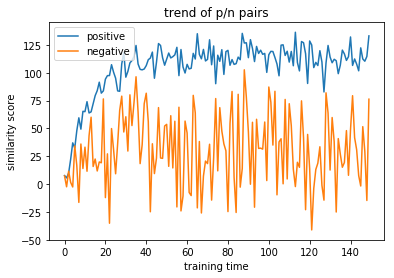

In [46]:
plt.plot(p_sample_list, label = "positive")
plt.plot(n_sample_list, label = "negative")
plt.title("trend of p/n pairs")
plt.xlabel('training time')
plt.ylabel("similarity score")
plt.legend()
plt.show()

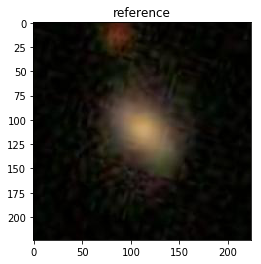

similarity 0.99284804


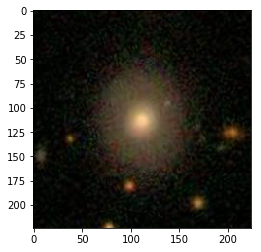

similarity 0.9971998


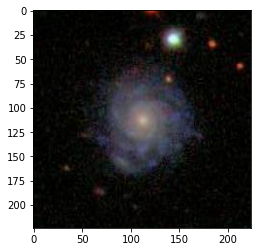

similarity 0.9900898


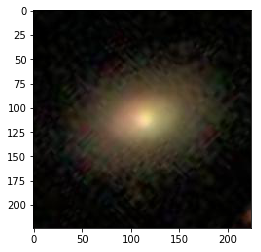

similarity 0.9937825


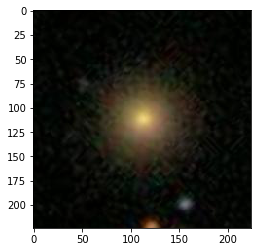

similarity 0.995318


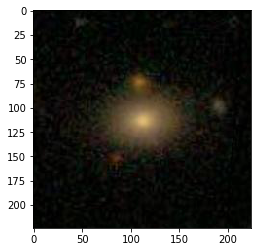

similarity 1.0


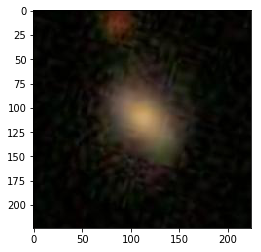

similarity 0.9943383


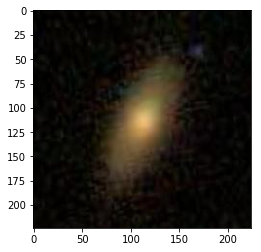

similarity 0.9983188


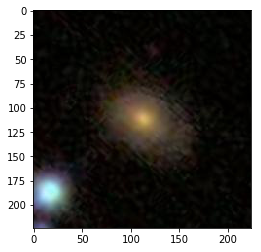

similarity 0.99533534


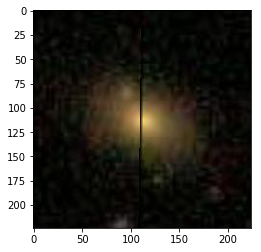

In [50]:
X_test_feature = []
ref_idx = 5
sample_image = torch.zeros((1, 3, 224, 224))

for i in range(3):
    sample_image[0, i, :, :] += data_test[ref_idx][:,:, i]

reference = simclr_model.encoder(sample_image.float().cuda()).detach().cpu().numpy()[0]
proj_reference = simclr_model.projection(simclr_model.encoder(sample_image.float().cuda())).detach().cpu().numpy()[0]
reference = reference/ np.linalg.norm(reference)
proj_reference = proj_reference / np.linalg.norm(proj_reference)

plt.imshow(sample_image[0].permute(1, 2, 0))
plt.title("reference")
plt.show()



for i, data in enumerate(data_test):
    sample_image = torch.zeros((1, 3, 224, 224))
    for idx in range(3):
        sample_image[0, idx, :, :] += data[:,:, idx]
    representation = simclr_model.encoder(sample_image.float().cuda())
    projection = simclr_model.projection(representation)
    representation = representation.detach().cpu().numpy()[0]
    projection = projection.detach().cpu().numpy()[0]
    projection = projection / np.linalg.norm(projection)
    
    X_test_feature.append(representation)
    representation = representation / np.linalg.norm(representation)
    #print("sum", sum(representation**2))
    similarity = np.dot(proj_reference, projection)
    #print(similarity)
    if similarity > 0.99:
        print('similarity', similarity)
    #print("representation", representation)
    #print("sum", sum(representation**2))
        plt.imshow(sample_image[0, :, :, :].permute(1, 2, 0))
        plt.show()
    if i == 10:
        break

In [48]:
# X_train_feature = []
# ref_idx = 5
# sample_image = torch.zeros((1, 3, 224, 224))

# for i in range(3):
#     sample_image[0, i, :, :] += data_train[ref_idx][:,:, i]

# reference = simclr_model.encoder(sample_image.float().cuda()).detach().cpu().numpy()[0]
# proj_reference = simclr_model.projection(simclr_model.encoder(sample_image.float().cuda())).detach().cpu().numpy()[0]
# reference = reference/ np.linalg.norm(reference)
# proj_reference = proj_reference / np.linalg.norm(proj_reference)

# plt.imshow(sample_image[0].permute(1, 2, 0))
# plt.title("reference")
# plt.show()



# for i, data in enumerate(data_train):
#     sample_image = torch.zeros((1, 3, 224, 224))
#     for idx in range(3):
#         sample_image[0, idx, :, :] += data[:,:, idx]
#     representation = simclr_model.encoder(sample_image.float().cuda())
#     projection = simclr_model.projection(representation)
#     representation = representation.detach().cpu().numpy()[0]
#     projection = projection.detach().cpu().numpy()[0]
#     projection = projection / np.linalg.norm(projection)
    
#     X_train_feature.append(representation)
#     representation = representation / np.linalg.norm(representation)
#     #print("sum", sum(representation**2))
#     similarity = np.dot(proj_reference, projection)
#     #print(similarity)
#     if similarity > 0.8:
#         print('similarity', similarity)
#     #print("representation", representation)
#     #print("sum", sum(representation**2))
#         plt.imshow(sample_image[0, :, :, :].permute(1, 2, 0))
#         plt.show()
#     if i == 20:
#         break